# Imports and Basic Settings

In [1]:
import numpy as np
import sep
from astropy.io import fits

### Setting up Matplotlib

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10.,8.]

### Read .fits image into a numpy 2-d array

In [3]:
fits_data = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
hdu = fits.open(fits_data)
data = hdu[0].data

### Plot fits data
Using the mean and standard deviation of the data, plot it and save the resulting plot as a figure.

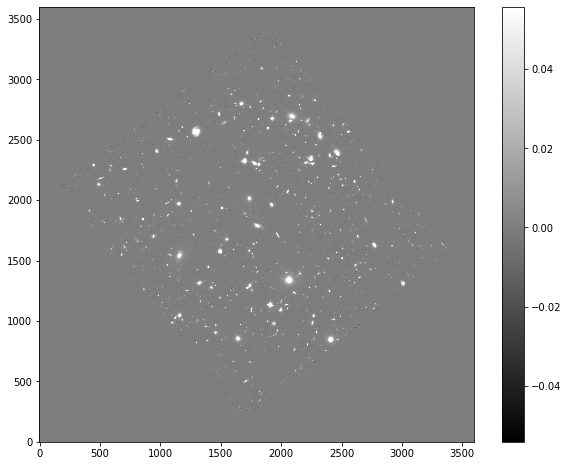

In [4]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('udf-105w-fits-image.png',bbox_inches='tight',pad_inches=0,dpi=600)

### Background Subtraction
In order to use object detection on the data, the data must be background subtracted. Using sep.Background, we can measure the spatially varying background from the data.

In [5]:
data = data.astype('float32')
bkg = sep.Background(data)
# also possible to mask colors
#bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)

Calculate global mean and noise from image background using background.globalback and background.globalrms respectively.

In [6]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In order to disply the background, transform it into a 2-d array so that it is the same size as the original fits image. Can either use background.back() or np.array(background)

In [7]:
bkg_image = bkg.back()

### Show the background

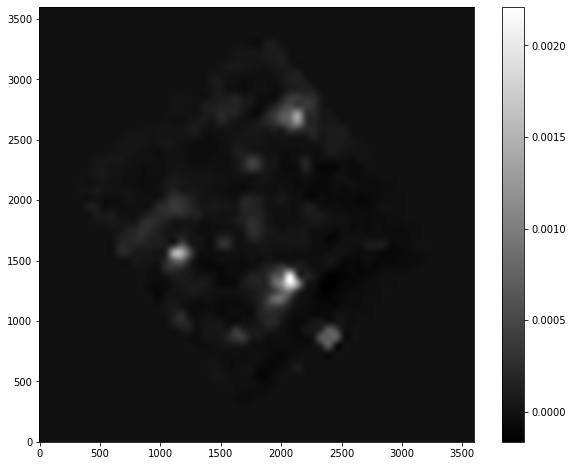

In [8]:
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('sep-tutorial-background.png',bbox_inches='tight',pad_inches=0,dpi=600)

### Calculate background noise
Like before, the data will be represented as a 2-d array.

In [9]:
bkg_rms = bkg.rms()

### Show the background noise

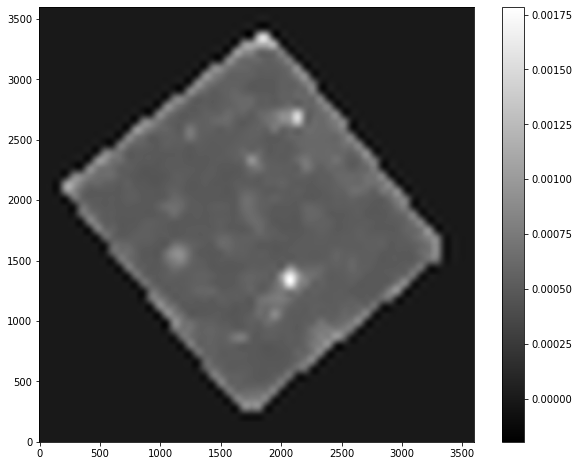

In [10]:
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('sep-tutorial-background-noise.png',bbox_inches='tight',pad_inches=0,dpi=600)

### Subtract the background from the data
This is necessary to perform object detection

In [11]:
data_sub = data - bkg
# or in place
# bkg.subfrom(data)

### Run Object Detection
Using the background-subtracted data above, run sep object detection. Since the background noise level is relatively flat, we can use a constant detection threshold of 1.5

In [12]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

### Print out the number of objects that were detected.

In [13]:
len(objects)

8636

### Plot Data and Circle Objects
First, we display the background-subtracted image using the mean and standard deviation of the data. Then, draw ellipses around each of the detected objects.

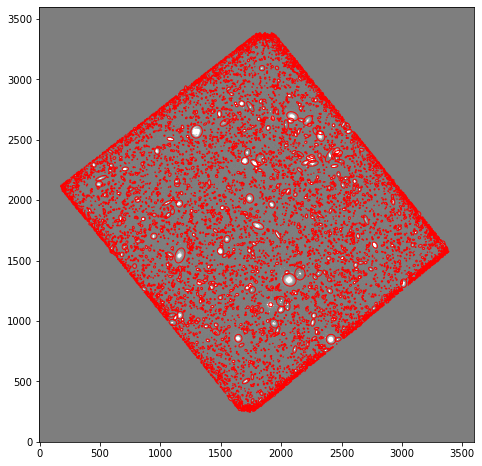

In [14]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('sep-tutorial-fits-ellipses.png',bbox_inches='tight',pad_inches=0,dpi=600)

### Object Fields
Detected objects have more fields than just x and y coordinates.

In [15]:
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

### Performing Aperture Photometry
Perform circular aperture photometry w/ 3 pixel radius from locations of detected objects.

In [16]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [50]:
print("max flux = ", flux.max(), "min flux", flux.min())
# show the objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

max flux =  807.2972835731507 min flux -1.061365427845663
object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


### Plot the Fluxes as a Histogram

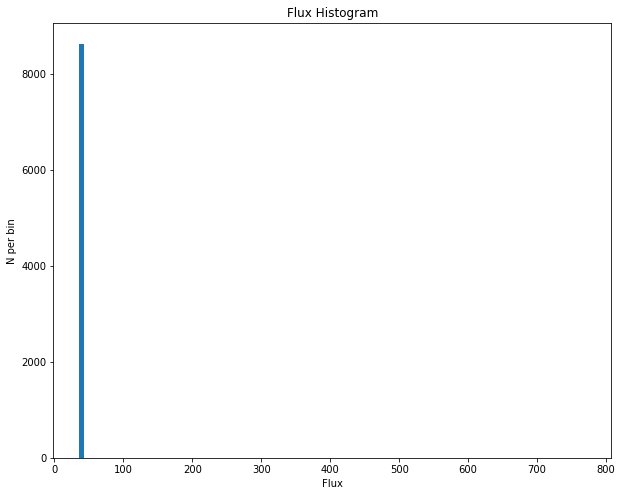

In [21]:
plt.hist(flux, rwidth=0.1)
plt.xlabel("Flux")
plt.ylabel("N per bin")
plt.title('Flux Histogram')

plt.savefig('histo.pdf', bbox_inches='tight', facecolor='white')

### Mean, Median, and Standard Deviation of Fluxes

In [42]:
mean = np.mean(flux)
median = np.median(flux)
std = np.std(flux)
print(f"Mean = {mean}, Median = {median}, Standard Deviation = {std}")

Mean = 0.3620178123990992, Median = 0.03097589430617518, Standard Deviation = 9.245665478260847


#### Finding the largest outlier

In [49]:
largest_outlier = 0
largest_outlier_coords = None
largest_outlier_std = 0
for i, f in enumerate(flux):
    num_std = (f - mean) / std
    if num_std > largest_outlier_std:
        largest_outlier = f
        largest_outlier_coords = (objects['a'][i], objects['b'][i])
        largest_outlier_std = num_std

print(f"Largest Outlier = {largest_outlier}")
print(f"Outlier Standard Deviation = {largest_outlier_std}")
print(f"Outlier Coordinates = {largest_outlier_coords}")

Largest Outlier = 807.2972835731507
Outlier Standard Deviation = 87.27714274954926
Outlier Coordinates = (5.627762794494629, 5.471261501312256)


### 3 Color Image

We'll need functions to rescale the image data and to quickly display the rescaled data

In [22]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m*100)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp,vpmin,vpmax

In [23]:
def fits_quicklook(data,fnx=10,fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp,vpmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp,vmin=vpmin,vmax=vpmax)

### Load in the data

In [32]:
# Define the file name
fits_data1 = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"
fits_data2 = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fits_data3 = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"

# Read in data
hdu1 = fits.open(fits_data1)
hdu2 = fits.open(fits_data2)
hdu3 = fits.open(fits_data3)

# Get the image data
data1 = hdu1[0].data
data2 = hdu2[0].data
data3 = hdu3[0].data

### Taking a look at the fits data

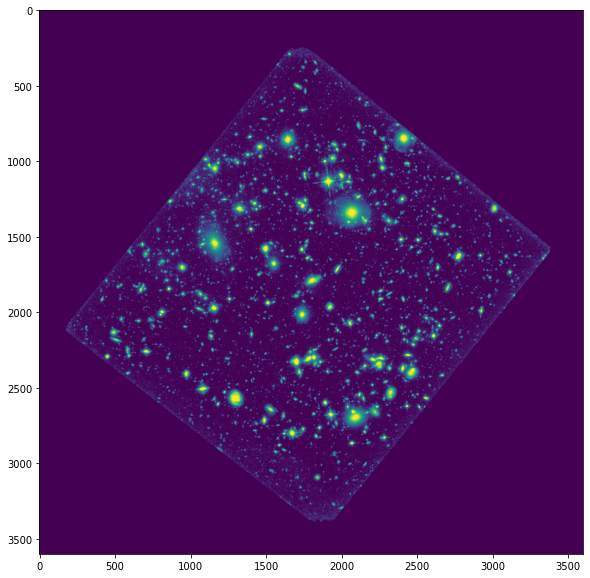

In [33]:
fits_quicklook(data1)

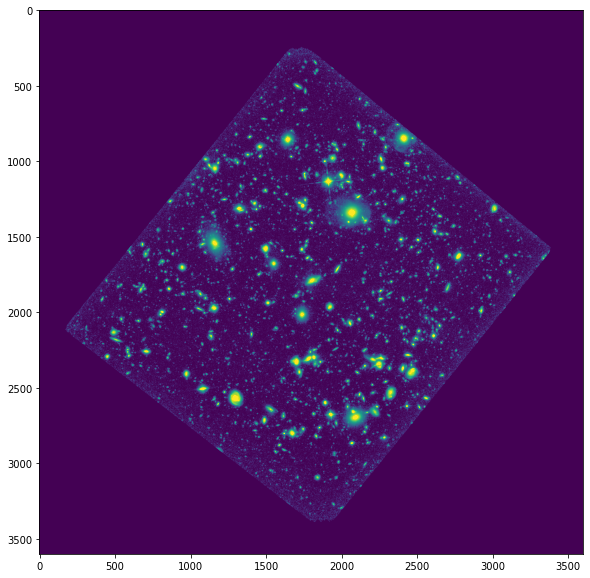

In [34]:
fits_quicklook(data2)

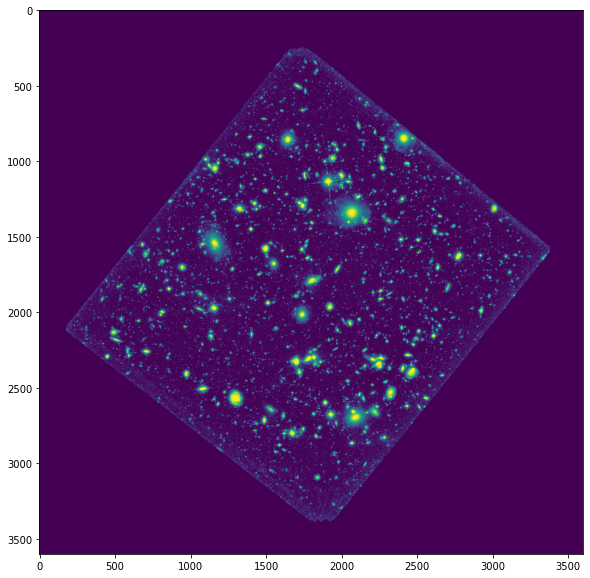

In [35]:
fits_quicklook(data3)

### 3-color image from the rescaled fits data

In [36]:
### use these rescaled images
data_1_res, d1min, d1max = rescale_image(data1)
data_2_res, d2min, d2max = rescale_image(data2)
data_3_res, d3min, d3max = rescale_image(data3)

In [37]:
data_1_res[data_1_res<d1min] = d1min
data_1_res[data_1_res>d1max] = d1max

data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max

data_3_res[data_3_res<d3min] = d3min
data_3_res[data_3_res>d3max] = d3max

### Create an RGB image

In [38]:
rgb = np.zeros((data_1_res.shape[0],data_1_res.shape[1],3))

In [39]:
rgb[:,:,0] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,1] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,2] = (data_1_res-d1min)/(d1max-d1min)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


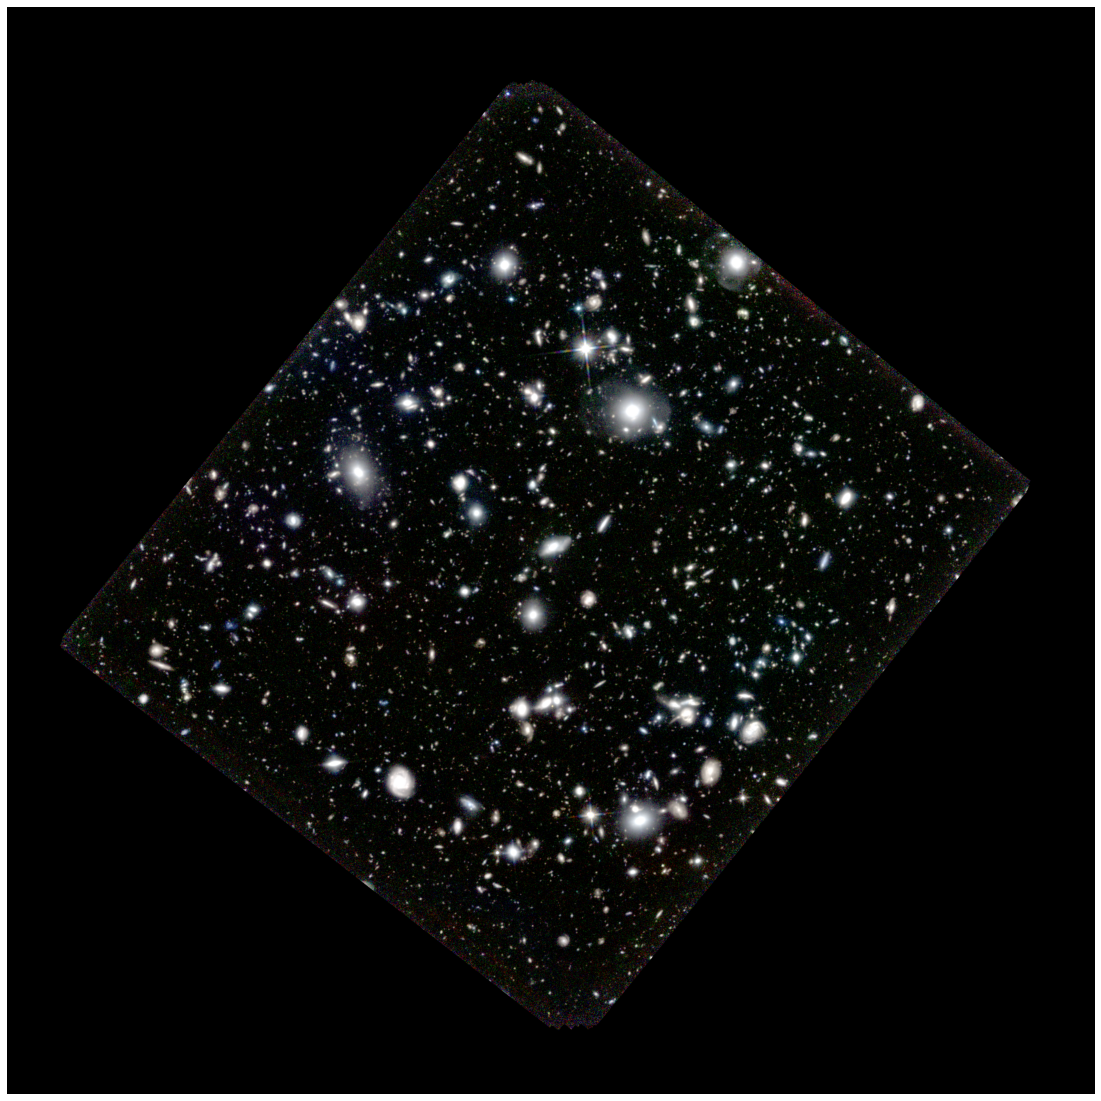

In [40]:
f, ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('udf_image.png',bbox_inches='tight',pad_inches=0,dpi=600)